# RealTime Image Denoising

This work is part of the experimental analysis for the paper Low Latency Video Denoising for Video Conferencing Using CNN Architectures 

Authors of this notebook, Masters Computer Science students, Seattle University Fall, 2022
 - Altanai Bisht
 - Ana Carolina Mendes
 - Justin Thoreson
Faculty Advisor 
- Dr Shadrokh Samavi

This work is under MIT License.

----------------------------------------

* RealTime Image Denoising
  * Construct dataset from Images
  * Detecting Noise
  * Add Noise To Images
    * Gaussian Noise
    * Uniform Noise
    * Impulse Noise
    * Random Noise (Sckit Image) s&p
    * Random Noise (Sckit Image)localvar
    * Random Noise (Sckit Image) salt
    * Random Noise (Sckit Image) pepper
    * Random Noise (Sckit Image)speckle
    * Pixalation Noise
* Analyzing the pixel distribution on few clean-noisy image pairs by ploting histograms
* Image Denoising
  * fastNlMeansDenoising
  * Median Blur
  * Gaussian Blur Denoising
  * Vanilla PCA
* Denoising Analyzer
  * PSNR using self defined function
  * PSNR using skimage.metrics

------------------------------------------------------

In [ ]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os
import tensorflow as tf

## Construct dataset from Images

In [ ]:
# dirpath = "/content/drive/MyDrive/RealtimeDenoising/WebRTCCapturesDataset/train"
dirpath = "/content/drive/MyDrive/RealtimeDenoising/WebRTCCapturesDataset/conftrain"

In [ ]:
## resize the screenhots 

train_images = sorted(os.listdir(dirpath))
imgsize=(240,320,3)
newsize=(320,240)
train_image = []
for im in train_images:
    img = tf.keras.utils.load_img(dirpath +"/"+ im)
    # img = img.resize(newsize)
    img = tf.keras.utils.img_to_array(img)
    img = img/255
    train_image.append(img)

train_df = np.array(train_image)
train_df.shape

(102, 1080, 1920, 3)

In [ ]:
i=20
img= cv2.imread(dirpath +"/Screenshot ("+str(i)+").png")
img = cv2.resize(img,(newsize))
# img=train_df[10]
img.shape

(240, 320, 3)

##  Detecting Noise

In [ ]:
# from skimage import io           # Only needed for web grabbing images, use cv2.imread for local image
def is_valid(image):

    # Convert image to HSV color space
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Calculate histogram of saturation channel
    s = cv2.calcHist([image], [1], None, [256], [0, 256])

    # Calculate percentage of pixels with saturation >= p
    p = 0.05
    s_perc = np.sum(s[int(p * 255):-1]) / np.prod(image.shape[0:2])

    plt.plot(s)
    plt.ylabel("Histogram of Saturation")
    plt.xlabel("Pixels")
    plt.plot([p * 255, p * 255], [0, np.max(s)], 'r')
    plt.text(p * 255 + 5, 0.9 * np.max(s), str(s_perc))
    plt.title("Percentage of pixels with saturation >= p")
    plt.show()

    # Percentage threshold; above: valid image, below: noise
    s_thr = 0.5
    return s_perc > s_thr

# matplotlib displays color in BGR format, we are converting that to RGB
def plot_rgb_img(img):
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  plt.show()

In [ ]:
dirpath

'/content/drive/MyDrive/RealtimeDenoising/WebRTCCapturesDataset/conftrain'

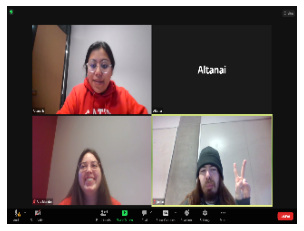

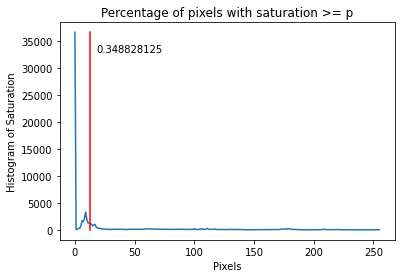

False


In [ ]:
# for img in [noise1, noise2, valid]:
#     print(is_valid(img))

# imread flag 
# cv2.IMREAD_COLOR: It specifies to load a color image. Any transparency of image will be neglected. It is the default flag. Alternatively, we can pass integer value 1 for this flag.
# cv2.IMREAD_GRAYSCALE: It specifies to load an image in grayscale mode. Alternatively, we can pass integer value 0 for this flag.
# cv2.IMREAD_UNCHANGED: It specifies to load an image as such including alpha channel. Alternatively, we can pass integer value -1 for this flag.
plot_rgb_img(img)

# plt.imshow(img)
noise1 = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
print(is_valid(noise1))

## Add Noise To Images

In [ ]:
def showNoiseEffect(img, noiseyimg, noisetype, gn_img):
  fig=plt.figure(dpi=300)

  fig.add_subplot(1,3,1)
  # plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.imshow(img)
  plt.axis("off")
  plt.title("Original",  fontsize = 8)

  if(noiseyimg is not None):
    fig.add_subplot(1,3,2)
    plt.imshow(noiseyimg)
    # plt.imshow(cv2.cvtColor(noiseyimg, cv2.COLOR_BGR2RGB))
    plt.imshow(noiseyimg)
    plt.axis("off")
    plt.title(noisetype,  fontsize = 8)

  fig.add_subplot(1,3,3)
  # plt.imshow(cv2.cvtColor(gn_img, cv2.COLOR_BGR2RGB))
  plt.imshow(gn_img)
  plt.axis("off")
  plt.title("Noisy Image \n"+ noisetype, fontsize = 8)

### Gaussian Noise

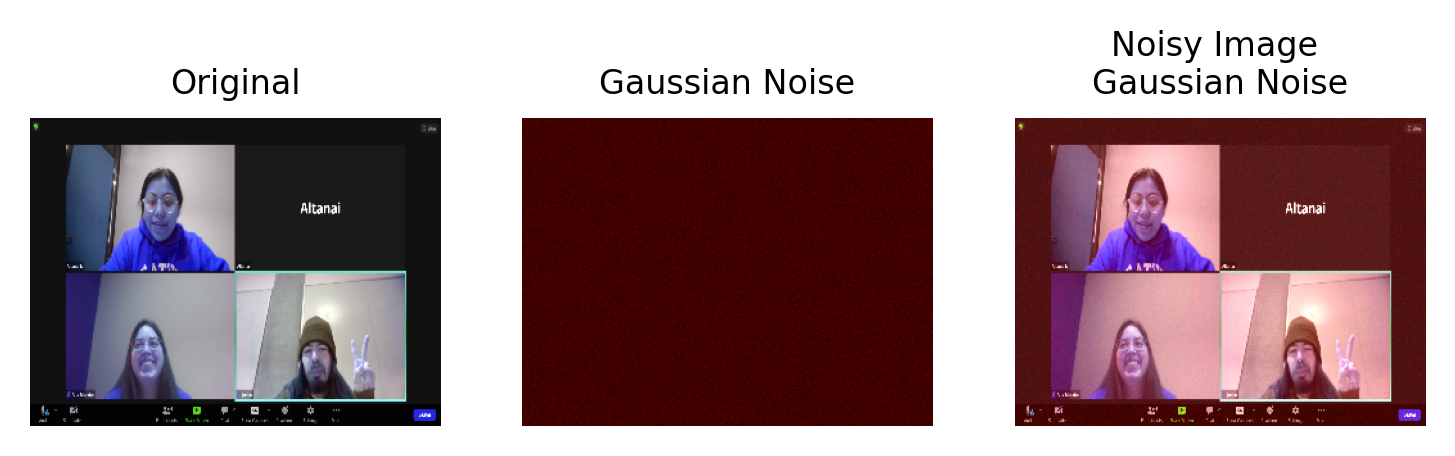

In [ ]:
gauss_noise=np.zeros(imgsize,dtype=np.uint8) # create a zero image with the same dimensions of the original image
cv2.randn(gauss_noise,128,20)  # random distribution to determine the pixel values of the noise (here mean of 128 and a sigma of 20)
gauss_noise=(gauss_noise*0.5).astype(np.uint8)

gn_img=cv2.add(img,gauss_noise)
showNoiseEffect(img, gauss_noise,"Gaussian Noise", gn_img)

### Uniform Noise

Uniform noise is signal dependant 

It is caused by the quantization of the pixels of an image to a number of discrete levels. It is generally created when analog data is converted to digital form

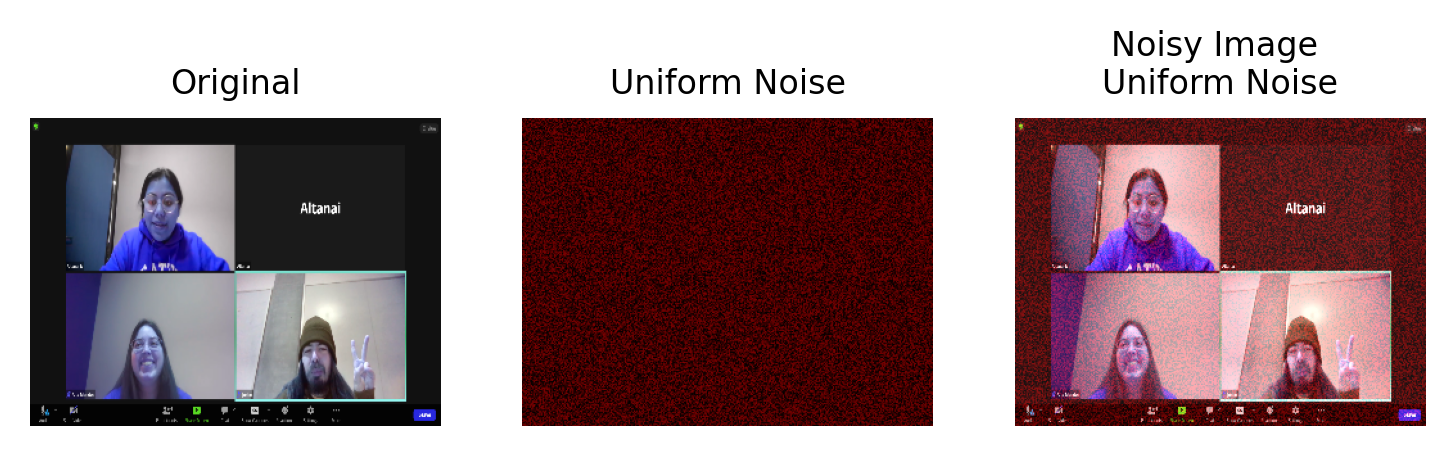

In [ ]:
uni_noise=np.zeros(imgsize,dtype=np.uint8)
cv2.randu(uni_noise,0,255)
uni_noise=(uni_noise*0.5).astype(np.uint8)

un_img=cv2.add(img,uni_noise)
showNoiseEffect(img, uni_noise,"Uniform Noise", un_img)

### Impulse Noise

"Salt and Pepper" noise is the sparse occurance of maximum (255) and minimum (0) pixel values in an image. This can be noticed as the presence of black pixels in bright regions and white pixels in dark regions. 
Caused by sudden disturbance in iomage signal such as erros in analog to digital conversion or bit

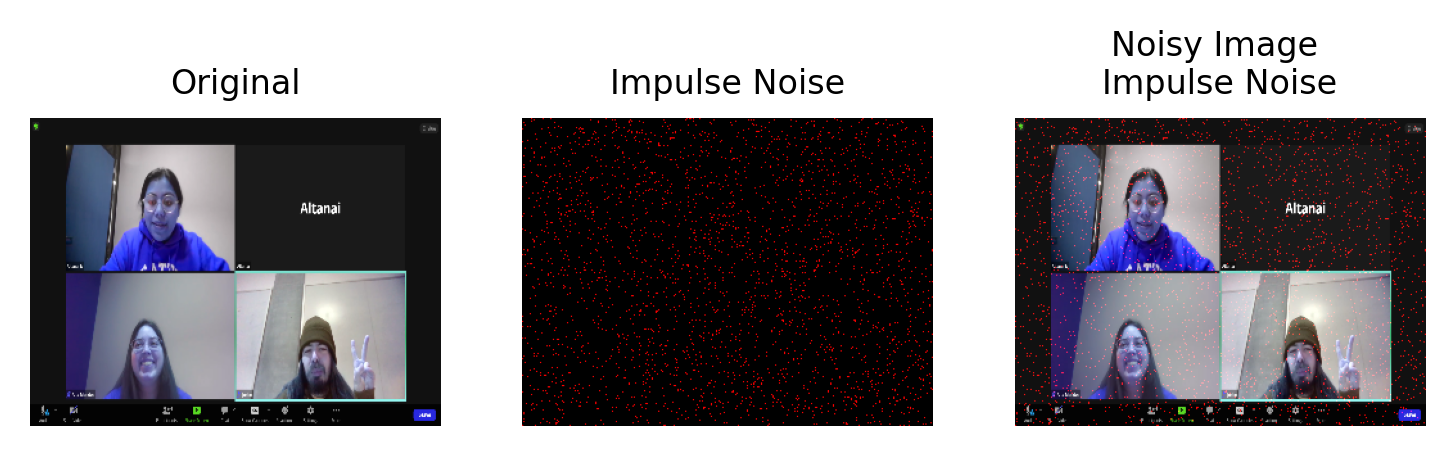

In [ ]:
 # create a distribution similar to that used in Uniform noise and apply binary thresholding to create a grid of black and white pixels.
 # intensity of the noise can be easily altered by changing the threshold value.

imp_noise=np.zeros(imgsize,dtype=np.uint8)
cv2.randu(imp_noise,0,255)
imp_noise=cv2.threshold(imp_noise,245,255,cv2.THRESH_BINARY)[1]

in_img=cv2.add(img,imp_noise)
showNoiseEffect(img, imp_noise,"Impulse Noise", in_img)

### Random Noise (Sckit Image) s&p

True

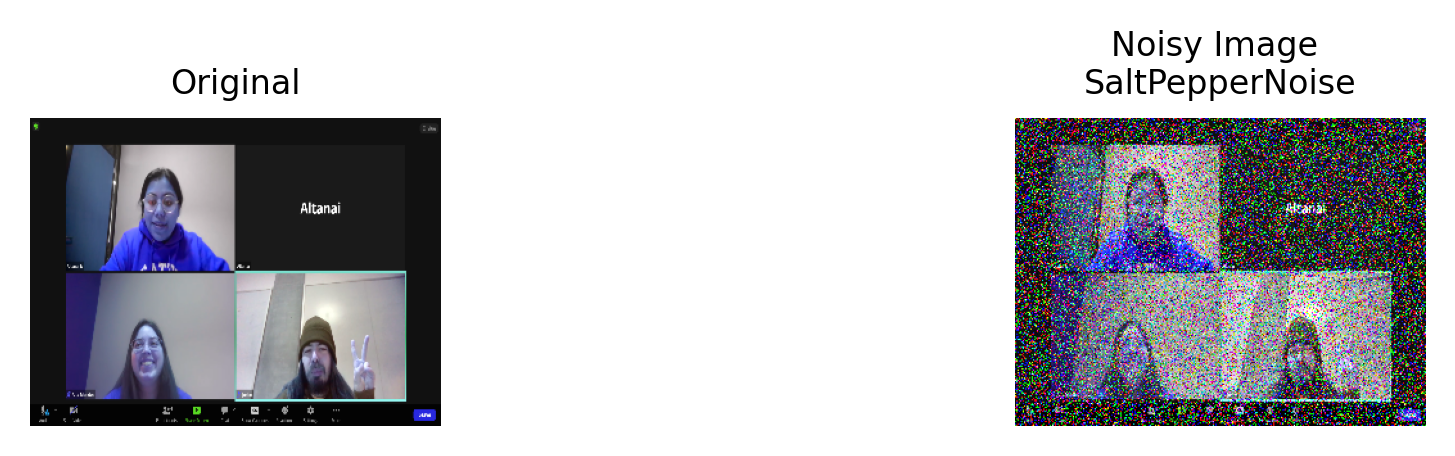

In [ ]:
from skimage.util import random_noise

noise_img = random_noise(img, mode='s&p',amount=0.3)  # salt-and-pepper noise to the image.
sp_img = np.array(255*noise_img, dtype = 'uint8')

noise_type= "SaltPepperNoise"
showNoiseEffect(img, None, noise_type, sp_img)
cv2.imwrite(noise_type+"_gnimg_"+str(i)+".jpg", sp_img)

### Random Noise (Sckit Image)localvar

True

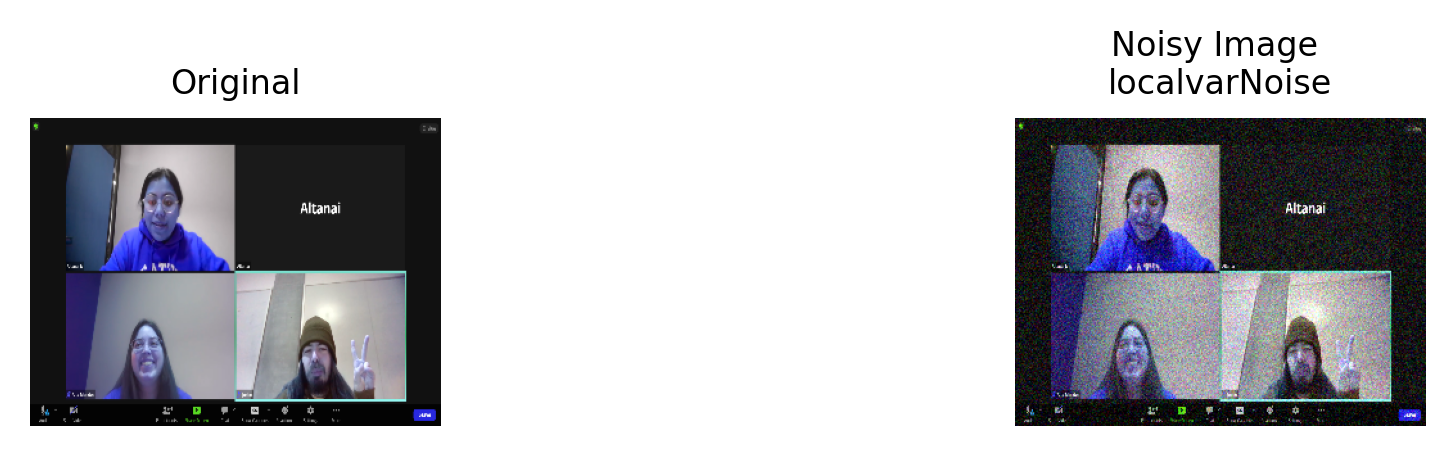

In [ ]:
noise_img = random_noise(img, mode='localvar')  # localvar noise to the image.
localvar_img = np.array(255*noise_img, dtype = 'uint8')

noise_type= "localvarNoise"
showNoiseEffect(img, None,noise_type, localvar_img)
cv2.imwrite(noise_type+"_gnimg_"+str(i)+".jpg", sp_img)

### Random Noise (Sckit Image) salt

True

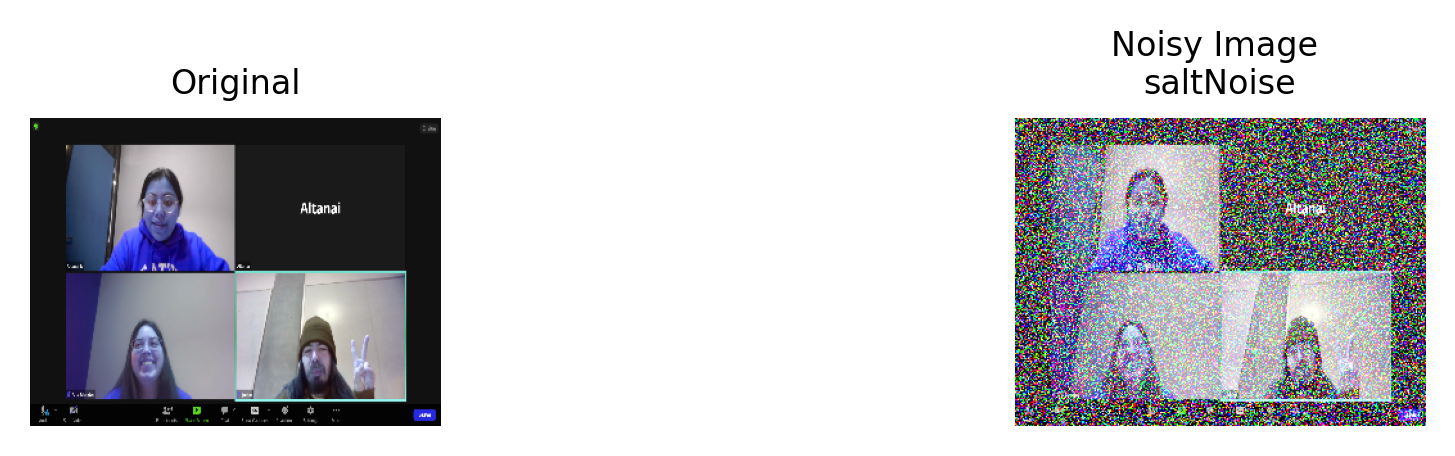

In [ ]:
noise_img = random_noise(img, mode='salt',amount=0.3)  # salt-and-pepper noise to the image.
salt_img = np.array(255*noise_img, dtype = 'uint8')

noise_type= "saltNoise"
showNoiseEffect(img, None,noise_type, salt_img)
cv2.imwrite(noise_type+"_gnimg_"+str(i)+".jpg", sp_img)

### Random Noise (Sckit Image) pepper

True

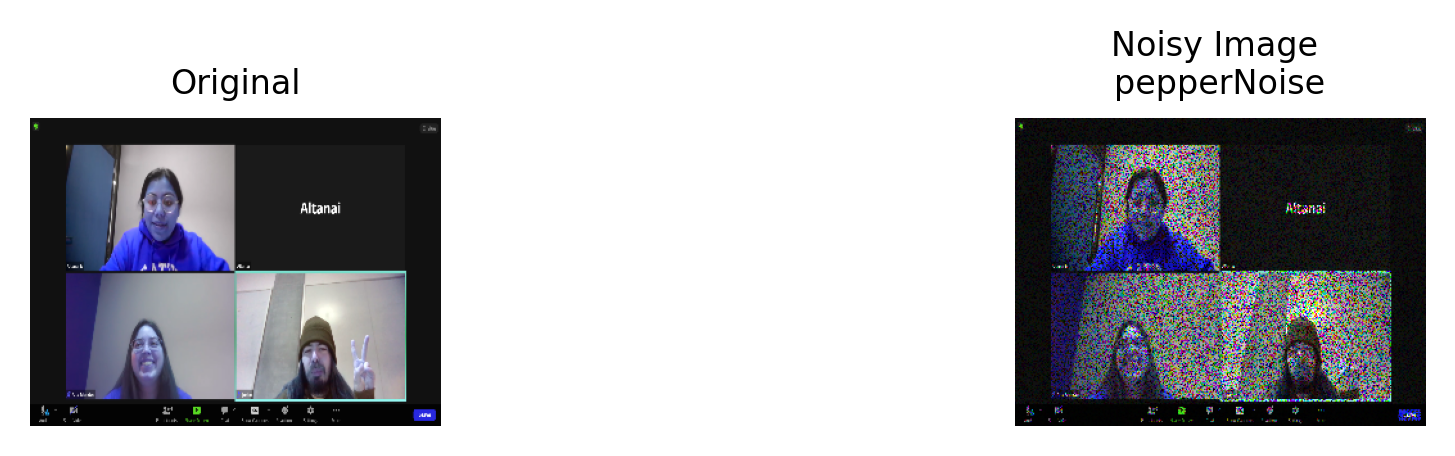

In [ ]:
noise_img = random_noise(img, mode='pepper',amount=0.3)  # salt-and-pepper noise to the image.
pepper_img = np.array(255*noise_img, dtype = 'uint8')

noise_type= "pepperNoise"
showNoiseEffect(img, None,noise_type, pepper_img)
cv2.imwrite(noise_type+"_gnimg_"+str(i)+".jpg", sp_img)

### Random Noise (Sckit Image)speckle

True

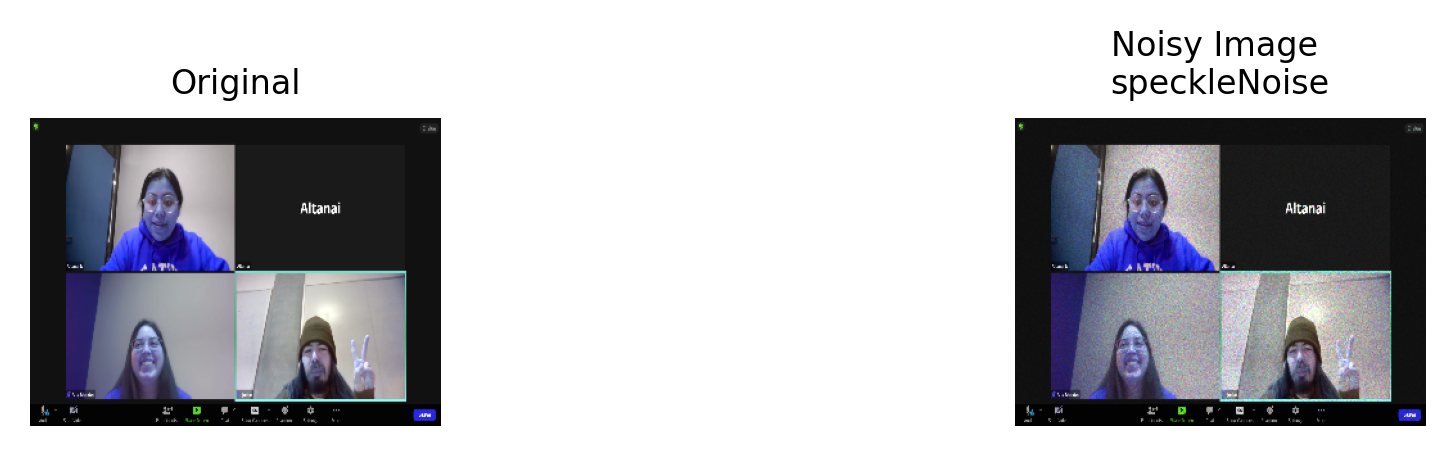

In [ ]:
noise_img = random_noise(img, mode='speckle')  # salt-and-pepper noise to the image.
speckle_img = np.array(255*noise_img, dtype = 'uint8')

noise_type= "speckleNoise"
showNoiseEffect(img, None,noise_type, speckle_img)
cv2.imwrite(noise_type+"_gnimg_"+str(i)+".jpg", sp_img)

### pixalation Noise


In [ ]:
#  pip install pillow

error: ignored

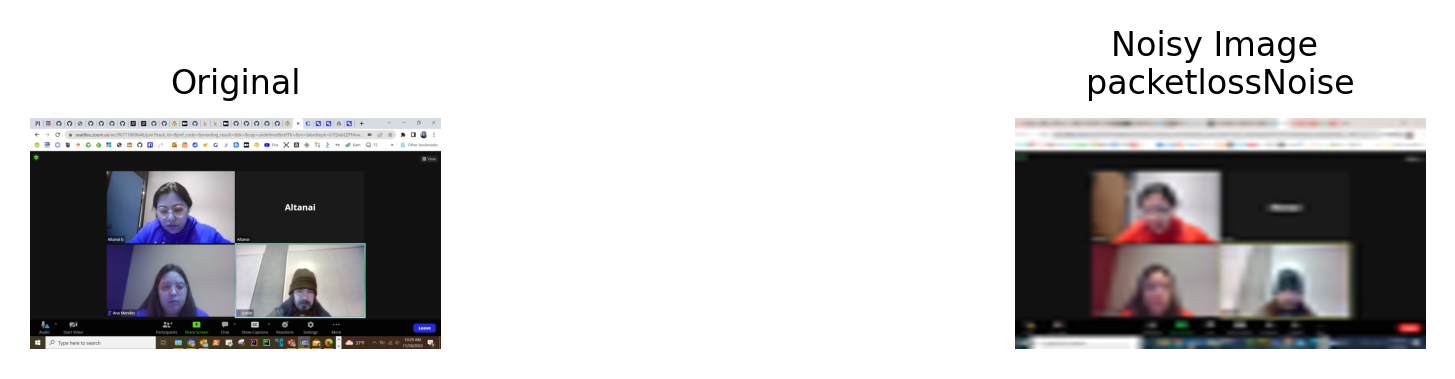

In [ ]:
from matplotlib import image
from PIL import Image

img2=Image.open(dirpath +"/Screenshot ("+str(i)+").png")
# cv2.imread(
imgSmall = img2.resize((64, 64))
# pixelated_img = imgSmall.resize(img2.size,Image.NEAREST)
pixelated_img = imgSmall.resize(img2.size)

noise_type= "packetlossNoise"
showNoiseEffect(img, None,noise_type, pixelated_img)
cv2.imwrite(noise_type+"_gnimg_"+str(i)+".jpg", pixelated_img)

# Analyzing the pixel distribution on few clean-noisy image pairs by ploting histograms


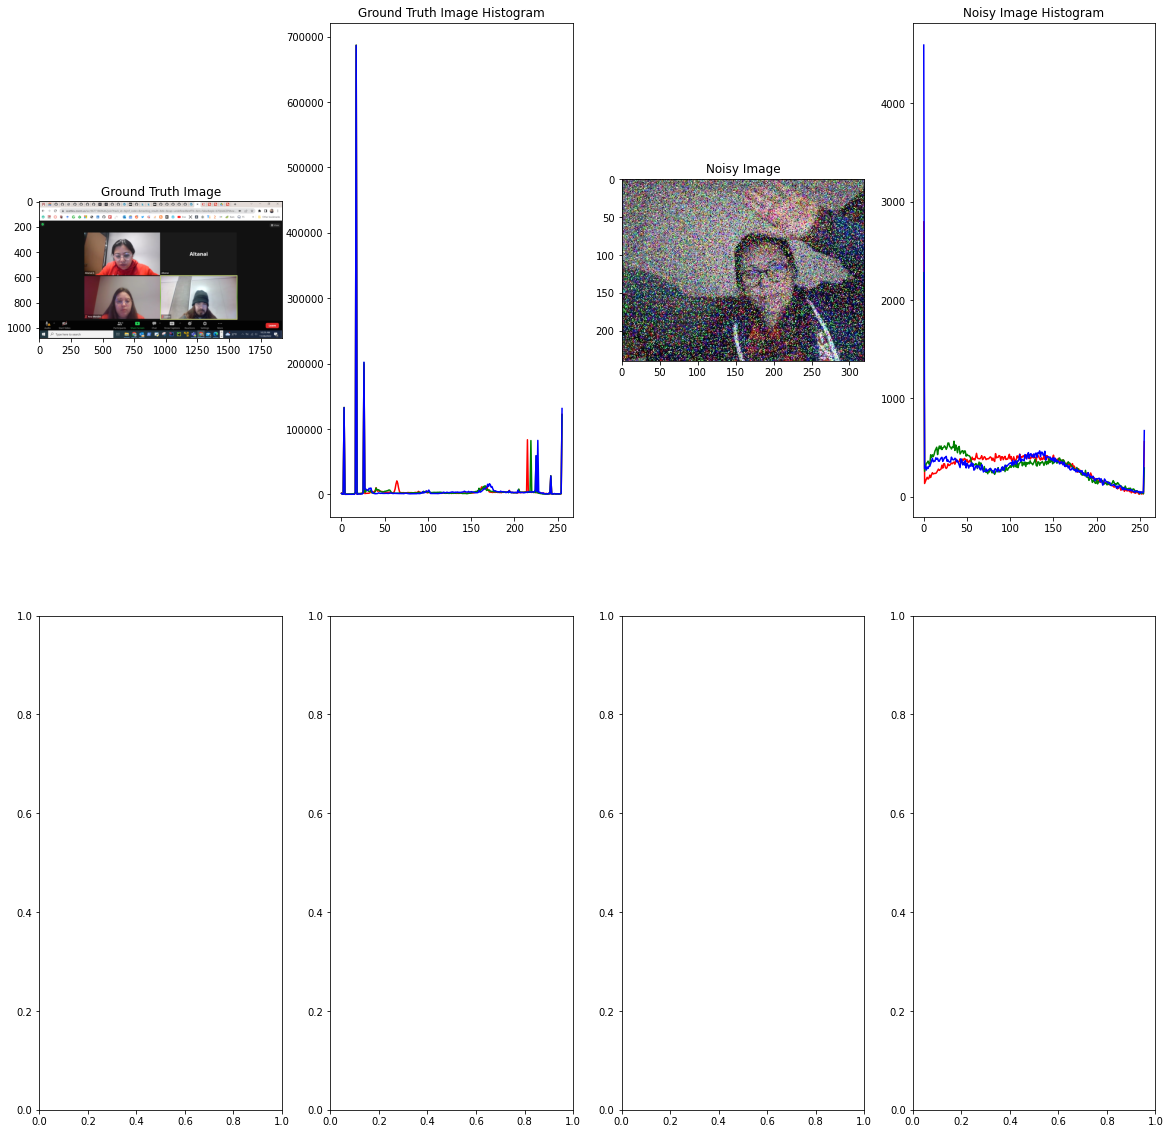

In [ ]:
import matplotlib.pyplot as plt
import cv2

fig, axes = plt.subplots(2,4,figsize=(20, 20))

i=0
for x in [1]:
    img = cv2.imread(dirpath +"/Screenshot ("+str(x)+").png")
    axes[i][0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[i][0].set_title('Ground Truth Image')

    axes[i][1].plot(cv2.calcHist([img],[0],None,[256],[0,256]),color='r')
    axes[i][1].plot(cv2.calcHist([img],[1],None,[256],[0,256]),color='g')
    axes[i][1].plot(cv2.calcHist([img],[2],None,[256],[0,256]),color='b')
    axes[i][1].set_title('Ground Truth Image Histogram')

    train_noisy_img = cv2.imread("/content/SaltPepperNoise_gnimg_"+str(x)+".jpg")
    axes[i][2].imshow(cv2.cvtColor(train_noisy_img, cv2.COLOR_BGR2RGB))
    axes[i][2].set_title('Noisy Image')

    axes[i][3].plot(cv2.calcHist([train_noisy_img],[0],None,[256],[0,256]),color='r')
    axes[i][3].plot(cv2.calcHist([train_noisy_img],[1],None,[256],[0,256]),color='g')
    axes[i][3].plot(cv2.calcHist([train_noisy_img],[2],None,[256],[0,256]),color='b')
    axes[i][3].set_title('Noisy Image Histogram')

    i=i+1

# Image Denoising

In [ ]:
def showDenoisingEffect(img, noisygnimg, noisetype, denoisedimg, denoisingtech="" ):
  fig=plt.figure(dpi=300)
  
  fig.add_subplot(1,3,1)
  plt.imshow(img,cmap='gray')
  plt.axis("off")
  plt.title("Original", fontsize = 8)

  fig.add_subplot(1,3,2)
  plt.imshow(noisygnimg,cmap='gray')
  plt.axis("off")
  plt.title(noisetype, fontsize = 8)

  fig.add_subplot(1,3,3)
  plt.imshow(denoisedimg,cmap='gray')
  plt.axis("off")
  plt.title("After Denoising\n"+ denoisingtech, fontsize = 8)

##  fastNlMeansDenoising

Non-local Means Denoising algorithm, and expects greyscale image with Gaussian white noise

In [ ]:
denoised_gn_fastNlMeans=cv2.fastNlMeansDenoising(gn_img,None,10,10)
showDenoisingEffect(img, gn_img , "with Gaussian Noise",denoised_gn_fastNlMeans, " fastNlMeansDenoising" )

In [ ]:
denoised_un_fastNlMeans=cv2.fastNlMeansDenoising(un_img,None,10,10)
showDenoisingEffect(img, un_img , "with Uniform Noise",denoised_un_fastNlMeans, " fastNlMeansDenoising" )

In [ ]:
denoised_in_fastNlMeans=cv2.fastNlMeansDenoising(in_img,None,10,10)
showDenoisingEffect(img, in_img , "with Impulse Noise",denoised_in_fastNlMeans, " fastNlMeansDenoising" )

## Median Blur

In [ ]:
blurred1=cv2.medianBlur(gn_img,3)
blurred2=cv2.medianBlur(un_img,3)
blurred3=cv2.medianBlur(in_img,3)

In [ ]:
showDenoisingEffect(img, gn_img , "with Gaussian Noise",blurred1 )

In [ ]:
showDenoisingEffect(img, gn_img , "with uniform Noise",blurred2 )

In [ ]:
showDenoisingEffect(img, in_img , "with Impulse Noise",blurred3 )

## Gaussian Blur Denoising 

 Gaussian Kernel in place of a box filter. Effective against Gaussian Noise.

In [ ]:
blurred1=cv2.GaussianBlur(gn_img,(3,3),0)
blurred2=cv2.GaussianBlur(un_img,(3,3),0)
blurred3=cv2.GaussianBlur(in_img,(3,3),0)

In [ ]:
showDenoisingEffect(img, gn_img , "with Gaussian Noise",blurred1, "Gaussian Blur" )
showDenoisingEffect(img, gn_img , "with uniform Noise",blurred2, "Gaussian Blur" )
showDenoisingEffect(img, in_img , "with Impulse Noise",blurred3, "Gaussian Blur" )

## Vanilla PCA 

PCA is a unsupervised dimensionality reduction technique

In [ ]:
# # Splitting the image in R,G,B arrays.
 
# blue,green,red = cv2.split(img) 
# #initialize PCA with first 20 principal components
# pca = PCA(20)
 
# #Applying to red channel and then applying inverse transform to transformed array.
# red_transformed = pca.fit_transform(red)
# red_inverted = pca.inverse_transform(red_transformed)
 
# #Applying to Green channel and then applying inverse transform to transformed array.
# green_transformed = pca.fit_transform(green)
# green_inverted = pca.inverse_transform(green_transformed)
 
# #Applying to Blue channel and then applying inverse transform to transformed array.
# blue_transformed = pca.fit_transform(blue)
# blue_inverted = pca.inverse_transform(blue_transformed)

# img_compressed = (np.dstack((red_inverted, red_inverted, red_inverted))).astype(np.uint8)
# plt.imshow(img_compressed)

In [ ]:
# from sklearn.decomposition import PCA
# pca = PCA(2)
# _converfted = pca.fit(gn_img.reshape(8,8))
# # pca.n_components_

# # for co in pca.components_:
# #   plt.imshow(co.reshape(8,8),cmap="gray")
# #   plt.show()

# Denoising Analyzer

In [ ]:
# #Custom function that computes the psnr and ssim values for images
# def psnr_and_ssim(X_test,y_test,model,model_type='Normal'):
#   psnr_nsy = 0.0
#   psnr_de_nsy = 0.0
#   ssim_nsy = 0.0
#   ssim_de_nsy = 0.0
#   for i in range(len(X_test)):
#     #getting the noisy images
#     nsy = X_test[i]

#     #getting the predicted images
#     pred = model.predict(nsy)

#     #getting the ground truth images
#     gt = y_test[i]

#     #Normalizing the images
#     gt = gt.astype("float32") / 255.0
#     nsy = nsy.astype("float32") / 255.0

#     #Computing psnr and ssim for test images
#     psnr_nsy += psnr(gt,nsy)
#     psnr_de_nsy += psnr(gt,pred)
#     ssim_nsy += ssim(gt,nsy,multichannel=True,data_range=nsy.max() - nsy.min())
#     ssim_de_nsy += ssim(gt,pred,multichannel=True,data_range=pred.max() - pred.min())

#   psnr_nsy = psnr_nsy/len(X_test)
#   psnr_de_nsy = psnr_de_nsy/len(X_test)
#   ssim_nsy = ssim_nsy/len(X_test)
#   ssim_de_nsy = ssim_de_nsy/len(X_test)
#   return psnr_nsy, psnr_de_nsy,ssim_nsy,ssim_de_nsy

### PSNR using self defined function

In [ ]:
from math import log10, sqrt 
  
def PSNR(original, denoiced): 
    mse = np.mean((original - denoiced) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr 

In [ ]:
plot_rgb_img(gn_img)
value = PSNR(gn_img, img)
print(f"PSNR value for Noisy image is {value} dB")

In [ ]:
plot_rgb_img(denoised_gn_fastNlMeans)
value1 = PSNR(gn_img, denoised_gn_fastNlMeans)
print(f"PSNR value for Denoised image is {value1} dB")

plot_rgb_img(denoised_un_fastNlMeans)
value2 = PSNR(gn_img, denoised_un_fastNlMeans)
print(f"PSNR value for Denoised image is {value2} dB")

plot_rgb_img(denoised_in_fastNlMeans)
value3 = PSNR(gn_img, denoised_in_fastNlMeans)
# value2 = PSNR(xtest[0], pred[0])
print(f"PSNR value for Denoised image is {value3} dB")

### PSNR using skimage.metrics

In [ ]:
import skimage.metrics as measure

psnr1 = measure.peak_signal_noise_ratio(img,gn_img)
psnr2 = measure.peak_signal_noise_ratio(gn_img,denoised_in_fastNlMeans)
print("PSNR GroundTruth vs noisy " + str(psnr1))
print("PSNR noisy vs denoised " +str(psnr2))
print("PSNR Improvement" + str(psnr2-psnr1))

ssim1 = measure.structural_similarity(img,gn_img,multichannel=True)
ssim2 = measure.structural_similarity(img,denoised_in_fastNlMeans,multichannel=True)

print("SSIM GroundTruth vs noisy " + str(ssim1))
print("SSIM noisy vs denoised " +str(ssim2))
print("SSIM Improvement" + str(ssim2-ssim1))

ValueError: ignored

In [ ]:
psnr1 = measure.peak_signal_noise_ratio(img,in_img)
psnr2 = measure.peak_signal_noise_ratio(img,denoised_in_fastNlMeans)
print("PSNR GroundTruth vs noisy " + str(psnr1))
print("PSNR noisy vs denoised " +str(psnr2))
print("PSNR Improvement" + str(psnr2-psnr1))

ssim1 = measure.structural_similarity(img,in_img,multichannel=True)
ssim2 = measure.structural_similarity(img,denoised_in_fastNlMeans,multichannel=True)
print("SSIM GroundTruth vs noisy " + str(ssim1))
print("SSIM noisy vs denoised " +str(ssim2))
print("SSIM Improvement" + str(ssim2-ssim1))